In [1]:
#==============================================================================
# CELL 1: IMPORT LIBRARIES
#==============================================================================
"""
Import semua libraries untuk SHAP analysis dan feature importance.
"""
# Data manipulation
import pandas as pd
import numpy as np
from collections import Counter

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# SHAP for model interpretation
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Utilities
import warnings
import json
import os
import joblib
from datetime import datetime
import time

warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Plot settings
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
sns.set_palette("husl")

# Initialize SHAP JavaScript for notebook
shap.initjs()

print("="*80)
print("FASE 5: SHAP ANALYSIS & FEATURE IMPORTANCE")
print("="*80)
print("\n✅ All libraries imported successfully!")
print("="*80)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


FASE 5: SHAP ANALYSIS & FEATURE IMPORTANCE

✅ All libraries imported successfully!


In [2]:
#==============================================================================
# CELL 2: LOAD DATA & TUNED MODEL
#==============================================================================
"""
Load preprocessed data dan tuned model dari Fase 4.
"""
print("\n" + "="*80)
print("📂 LOADING DATA & TUNED MODEL")
print("="*80)

# Load training data
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()

# Load test data
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# Load tuned model from Fase 4
tuned_model = joblib.load('../models/tuned_rf_model.pkl')

# Load baseline feature importance for comparison
baseline_importance = pd.read_csv('../results/metrics/03_baseline_feature_importance.csv')

# Load tuning results
with open('../results/metrics/04_tuning_results.json', 'r') as f:
    tuning_results = json.load(f)

print("\n✅ Data Loaded:")
print(f"  • Training samples: {len(X_train)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Features: {X_train.shape[1]}")

# Get feature names
feature_names = X_train.columns.tolist()
print(f"\n✅ Feature Names ({len(feature_names)}):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

print(f"\n✅ Tuned Model Info:")
print(f"  • Type: {type(tuned_model).__name__}")
print(f"  • n_estimators: {tuned_model.n_estimators}")
print(f"  • max_depth: {tuned_model.max_depth}")
print(f"  • Test ROC-AUC: {tuning_results['tuned_model_performance']['test']['ROC-AUC']:.4f}")

print("\n✅ Class Distribution:")
train_dist = Counter(y_train)
test_dist = Counter(y_test)
print(f"  • Training: Class 0={train_dist[0]}, Class 1={train_dist[1]}")
print(f"  • Test: Class 0={test_dist[0]}, Class 1={test_dist[1]}")

print("\n" + "="*80)


📂 LOADING DATA & TUNED MODEL

✅ Data Loaded:
  • Training samples: 1508
  • Test samples: 377
  • Features: 24

✅ Feature Names (24):
   1. Age_Encoded
   2. Gender_Encoded
   3. Education_Encoded
   4. country_Australia
   5. country_Canada
   6. country_New Zealand
   7. country_Other
   8. country_Republic of Ireland
   9. country_UK
  10. country_USA
  11. ethnicity_Asian
  12. ethnicity_Black
  13. ethnicity_Mixed-Black/Asian
  14. ethnicity_Mixed-White/Asian
  15. ethnicity_Mixed-White/Black
  16. ethnicity_Other
  17. ethnicity_White
  18. Nscore
  19. Escore
  20. Oscore
  21. Ascore
  22. Cscore
  23. Impulsive
  24. SS

✅ Tuned Model Info:
  • Type: RandomForestClassifier
  • n_estimators: 500
  • max_depth: 20
  • Test ROC-AUC: 0.9347

✅ Class Distribution:
  • Training: Class 0=568, Class 1=940
  • Test: Class 0=142, Class 1=235



In [3]:
#==============================================================================
# CELL 3: GINI IMPORTANCE (BUILT-IN)
#==============================================================================
"""
Extract dan analyze built-in Gini feature importance dari tuned model.
"""
print("\n" + "="*80)
print("📊 GINI FEATURE IMPORTANCE (Built-in)")
print("="*80)

# Get feature importances
gini_importances = tuned_model.feature_importances_

# Create DataFrame
gini_df = pd.DataFrame({
    'Feature': feature_names,
    'Gini_Importance': gini_importances
}).sort_values('Gini_Importance', ascending=False).reset_index(drop=True)

# Add rank and cumulative
gini_df['Rank'] = range(1, len(gini_df) + 1)
gini_df['Cumulative'] = gini_df['Gini_Importance'].cumsum()
gini_df['Cumulative_Pct'] = gini_df['Cumulative'] * 100

print("\n✅ TOP 10 MOST IMPORTANT FEATURES (Gini):")
print("="*80)
print(gini_df.head(10).to_string(index=False))

print("\n✅ Feature Importance Statistics:")
print(f"  • Mean importance: {gini_importances.mean():.4f}")
print(f"  • Std importance: {gini_importances.std():.4f}")
print(f"  • Max importance: {gini_importances.max():.4f} ({gini_df.iloc[0]['Feature']})")
print(f"  • Min importance: {gini_importances.min():.4f}")

# Feature contribution analysis
top5_contrib = gini_df.head(5)['Gini_Importance'].sum() * 100
top10_contrib = gini_df.head(10)['Gini_Importance'].sum() * 100
top15_contrib = gini_df.head(15)['Gini_Importance'].sum() * 100

print(f"\n✅ Feature Contribution:")
print(f"  • Top 5 features:  {top5_contrib:.2f}%")
print(f"  • Top 10 features: {top10_contrib:.2f}%")
print(f"  • Top 15 features: {top15_contrib:.2f}%")

# Features needed for 80% and 90% importance
n_features_80 = (gini_df['Cumulative'] <= 0.80).sum() + 1
n_features_90 = (gini_df['Cumulative'] <= 0.90).sum() + 1

print(f"\n✅ Cumulative Importance:")
print(f"  • {n_features_80} features capture 80% importance")
print(f"  • {n_features_90} features capture 90% importance")

print("\n" + "="*80)


📊 GINI FEATURE IMPORTANCE (Built-in)

✅ TOP 10 MOST IMPORTANT FEATURES (Gini):
          Feature  Gini_Importance  Rank  Cumulative  Cumulative_Pct
       country_UK           0.2008     1      0.2008         20.0846
               SS           0.1351     2      0.3360         33.5960
      country_USA           0.1293     3      0.4652         46.5229
      Age_Encoded           0.1023     4      0.5675         56.7482
           Oscore           0.1000     5      0.6675         66.7472
           Cscore           0.0772     6      0.7446         74.4625
Education_Encoded           0.0591     7      0.8038         80.3772
        Impulsive           0.0435     8      0.8473         84.7294
           Nscore           0.0414     9      0.8887         88.8690
   Gender_Encoded           0.0386    10      0.9273         92.7337

✅ Feature Importance Statistics:
  • Mean importance: 0.0417
  • Std importance: 0.0543
  • Max importance: 0.2008 (country_UK)
  • Min importance: 0.0000

✅ Fe


📊 VISUALIZING GINI IMPORTANCE


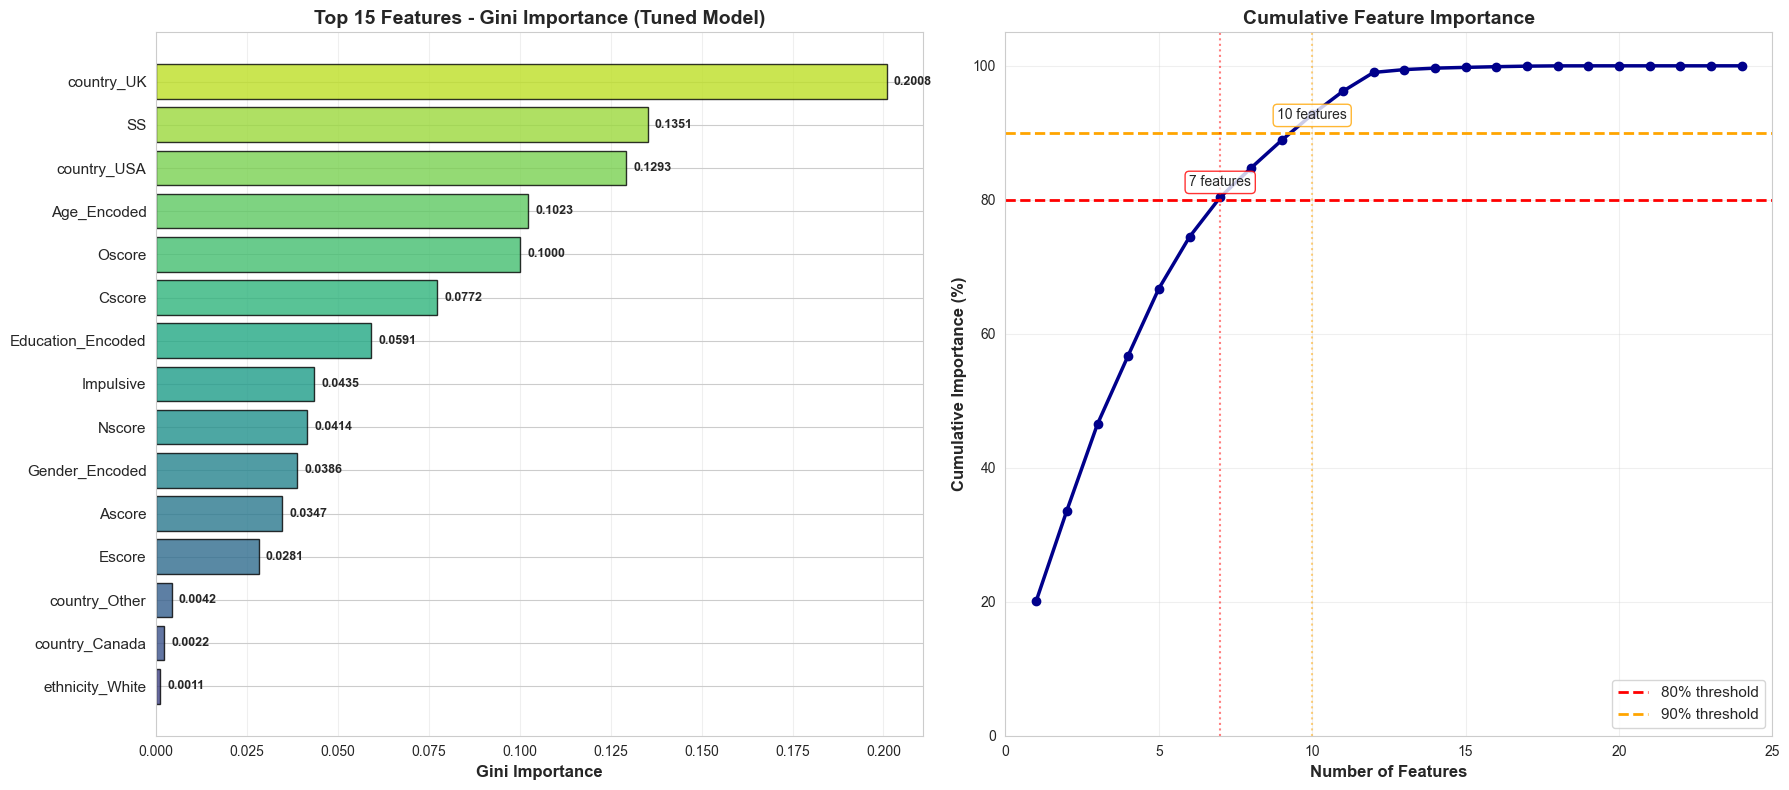


✅ Gini importance visualization saved!
  • File: ../results/figures/29_gini_importance_tuned.png



In [4]:
#==============================================================================
# CELL 4: VISUALIZE GINI IMPORTANCE
#==============================================================================
"""
Visualize Gini feature importance.
"""
print("\n" + "="*80)
print("📊 VISUALIZING GINI IMPORTANCE")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Horizontal bar chart (Top 15)
ax = axes[0]
top15 = gini_df.head(15).sort_values('Gini_Importance', ascending=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.9, 15))

bars = ax.barh(range(15), top15['Gini_Importance'], color=colors, 
               alpha=0.8, edgecolor='black')
ax.set_yticks(range(15))
ax.set_yticklabels(top15['Feature'], fontsize=11)
ax.set_xlabel('Gini Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features - Gini Importance (Tuned Model)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top15.iterrows()):
    ax.text(row['Gini_Importance'] + 0.002, i,
            f"{row['Gini_Importance']:.4f}",
            va='center', fontsize=9, fontweight='bold')

# 2. Cumulative importance curve
ax = axes[1]
ax.plot(gini_df['Rank'], gini_df['Cumulative_Pct'], 
        marker='o', linewidth=2.5, markersize=6, color='darkblue')
ax.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% threshold')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance (%)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(alpha=0.3)
ax.set_xlim([0, len(gini_df) + 1])
ax.set_ylim([0, 105])

# Annotate 80% and 90% points
ax.axvline(x=n_features_80, color='red', linestyle=':', alpha=0.5)
ax.axvline(x=n_features_90, color='orange', linestyle=':', alpha=0.5)
ax.text(n_features_80, 82, f'{n_features_80} features',
        ha='center', fontsize=10, bbox=dict(boxstyle='round', 
        facecolor='white', alpha=0.8, edgecolor='red'))
ax.text(n_features_90, 92, f'{n_features_90} features',
        ha='center', fontsize=10, bbox=dict(boxstyle='round', 
        facecolor='white', alpha=0.8, edgecolor='orange'))

plt.tight_layout()
plt.savefig('../results/figures/29_gini_importance_tuned.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gini importance visualization saved!")
print("  • File: ../results/figures/29_gini_importance_tuned.png")

print("\n" + "="*80)

In [5]:
#==============================================================================
# CELL 5: PERMUTATION IMPORTANCE
#==============================================================================
"""
Calculate permutation importance pada test set.
"""
print("\n" + "="*80)
print("🔄 PERMUTATION IMPORTANCE ANALYSIS")
print("="*80)

print("\n⚙️  Computing permutation importance...")
print("  • This may take 2-3 minutes...")
print("  • Using test set for unbiased estimates")

start_time = time.time()

# Calculate permutation importance
perm_importance = permutation_importance(
    tuned_model, 
    X_test, 
    y_test,
    n_repeats=30,  # 30 repeats for stable estimates
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

perm_time = time.time() - start_time

print(f"\n✅ Permutation importance calculated in {perm_time:.2f}s")

# Create DataFrame
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Perm_Importance_Mean': perm_importance.importances_mean,
    'Perm_Importance_Std': perm_importance.importances_std
}).sort_values('Perm_Importance_Mean', ascending=False).reset_index(drop=True)

perm_df['Rank'] = range(1, len(perm_df) + 1)

print("\n✅ TOP 10 FEATURES (Permutation Importance):")
print("="*80)
print(perm_df.head(10).to_string(index=False))

print("\n✅ Permutation Importance Statistics:")
print(f"  • Mean importance: {perm_importance.importances_mean.mean():.4f}")
print(f"  • Std of means: {perm_importance.importances_mean.std():.4f}")
print(f"  • Max importance: {perm_importance.importances_mean.max():.4f} ({perm_df.iloc[0]['Feature']})")

print("\n" + "="*80)


🔄 PERMUTATION IMPORTANCE ANALYSIS

⚙️  Computing permutation importance...
  • This may take 2-3 minutes...
  • Using test set for unbiased estimates

✅ Permutation importance calculated in 14.61s

✅ TOP 10 FEATURES (Permutation Importance):
          Feature  Perm_Importance_Mean  Perm_Importance_Std  Rank
       country_UK                0.0340               0.0100     1
      country_USA                0.0228               0.0076     2
               SS                0.0221               0.0053     3
      Age_Encoded                0.0160               0.0042     4
           Oscore                0.0155               0.0054     5
           Cscore                0.0065               0.0033     6
Education_Encoded                0.0062               0.0027     7
   Gender_Encoded                0.0056               0.0020     8
           Escore                0.0011               0.0012     9
           Nscore                0.0011               0.0020    10

✅ Permutation Impor


📊 VISUALIZING PERMUTATION IMPORTANCE


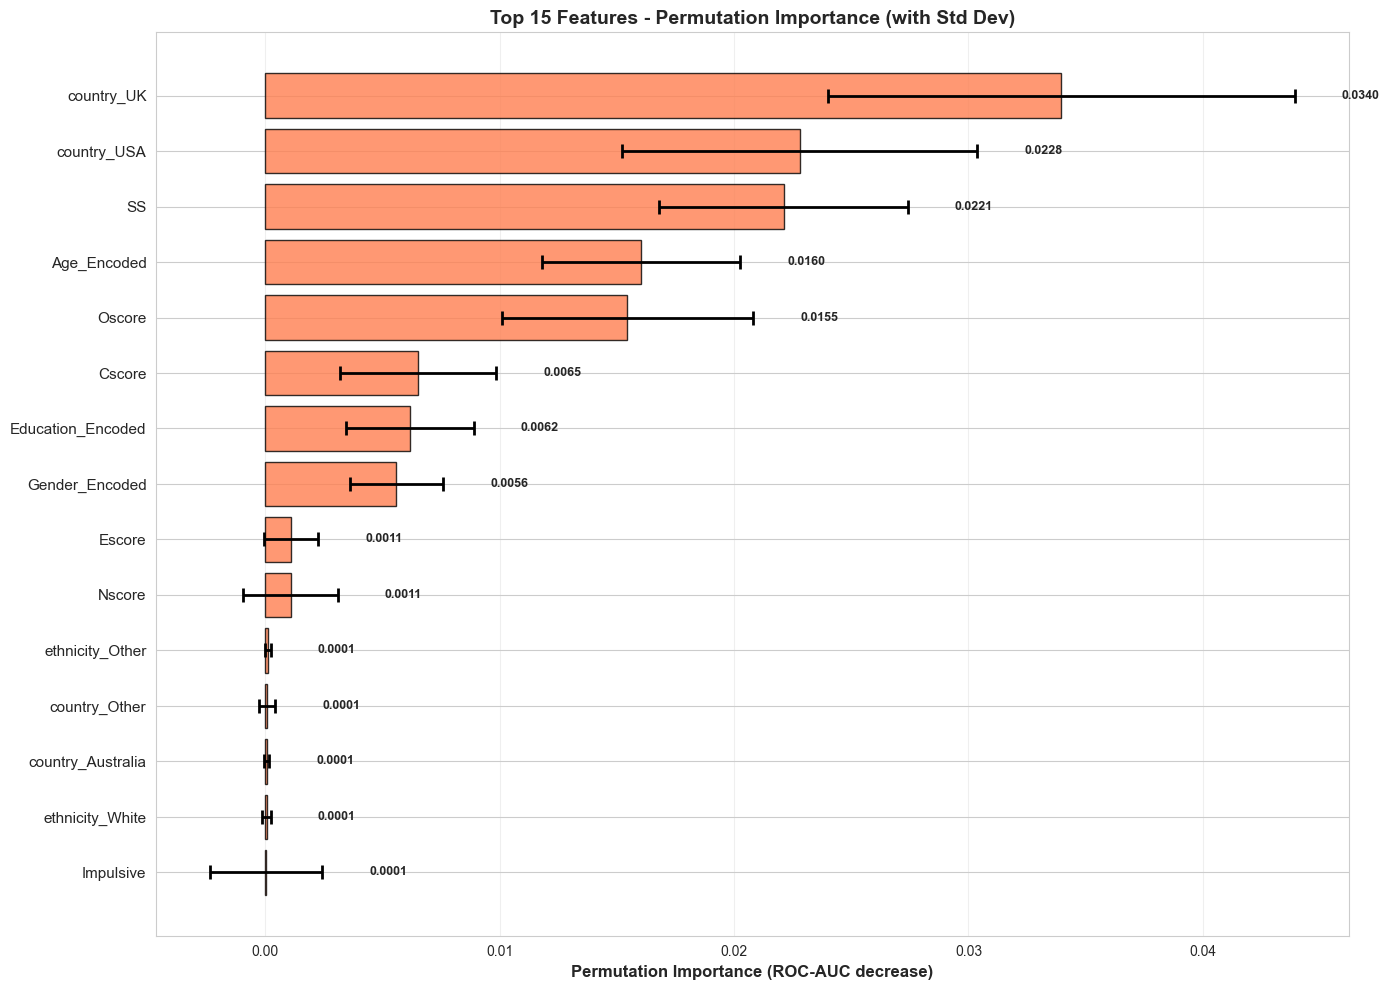


✅ Permutation importance visualization saved!
  • File: ../results/figures/30_permutation_importance.png



In [6]:
#==============================================================================
# CELL 6: VISUALIZE PERMUTATION IMPORTANCE
#==============================================================================
"""
Visualize permutation importance dengan error bars.
"""
print("\n" + "="*80)
print("📊 VISUALIZING PERMUTATION IMPORTANCE")
print("="*80)

fig, ax = plt.subplots(figsize=(14, 10))

# Top 15 features
top15_perm = perm_df.head(15).sort_values('Perm_Importance_Mean', ascending=True)

# Create horizontal bar plot with error bars
y_pos = np.arange(len(top15_perm))
bars = ax.barh(y_pos, top15_perm['Perm_Importance_Mean'],
               xerr=top15_perm['Perm_Importance_Std'],
               color='coral', alpha=0.8, edgecolor='black',
               error_kw={'elinewidth': 2, 'capsize': 5, 'capthick': 2})

ax.set_yticks(y_pos)
ax.set_yticklabels(top15_perm['Feature'], fontsize=11)
ax.set_xlabel('Permutation Importance (ROC-AUC decrease)', 
              fontsize=12, fontweight='bold')
ax.set_title('Top 15 Features - Permutation Importance (with Std Dev)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top15_perm.iterrows()):
    ax.text(row['Perm_Importance_Mean'] + row['Perm_Importance_Std'] + 0.002, i,
            f"{row['Perm_Importance_Mean']:.4f}",
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/30_permutation_importance.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Permutation importance visualization saved!")
print("  • File: ../results/figures/30_permutation_importance.png")

print("\n" + "="*80)

In [7]:
#==============================================================================
# CELL 7: INITIALIZE SHAP EXPLAINER
#==============================================================================
"""
Initialize SHAP TreeExplainer dan calculate SHAP values.
"""
print("\n" + "="*80)
print("🔍 INITIALIZING SHAP ANALYSIS")
print("="*80)

print("\n⚙️  Creating SHAP TreeExplainer...")
print("  • Using TreeExplainer (optimized for Random Forest)")

# Create SHAP explainer
explainer = shap.TreeExplainer(tuned_model)

print("✅ Explainer created successfully!")

print("\n⚙️  Computing SHAP values for test set...")
print("  • This may take 2-5 minutes...")
print(f"  • Processing {len(X_test)} samples")

start_time = time.time()

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# For binary classification, shap_values is a list [class_0, class_1]
# We want class 1 (drug user)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
    shap_values_class0 = shap_values[0]
else:
    shap_values_class1 = shap_values

shap_time = time.time() - start_time

print(f"\n✅ SHAP values computed in {shap_time:.2f}s")
print(f"  • Shape: {shap_values_class1.shape}")
print(f"  • Base value: {explainer.expected_value[1]:.4f}")

# Calculate mean absolute SHAP values
shap_importance = np.abs(shap_values_class1).mean(axis=0)

# Create DataFrame
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False).reset_index(drop=True)

shap_df['Rank'] = range(1, len(shap_df) + 1)

print("\n✅ TOP 10 FEATURES (SHAP Values):")
print("="*80)
print(shap_df.head(10).to_string(index=False))

print("\n" + "="*80)


🔍 INITIALIZING SHAP ANALYSIS

⚙️  Creating SHAP TreeExplainer...
  • Using TreeExplainer (optimized for Random Forest)
✅ Explainer created successfully!

⚙️  Computing SHAP values for test set...
  • This may take 2-5 minutes...
  • Processing 377 samples

✅ SHAP values computed in 2.15s
  • Shape: (377, 24)
  • Base value: 0.6232

✅ TOP 10 FEATURES (SHAP Values):
          Feature  SHAP_Importance  Rank
       country_UK           0.0949     1
               SS           0.0655     2
      country_USA           0.0638     3
      Age_Encoded           0.0492     4
           Oscore           0.0466     5
           Cscore           0.0358     6
Education_Encoded           0.0314     7
   Gender_Encoded           0.0308     8
        Impulsive           0.0192     9
           Ascore           0.0150    10




📊 GENERATING SHAP SUMMARY PLOT (Beeswarm)


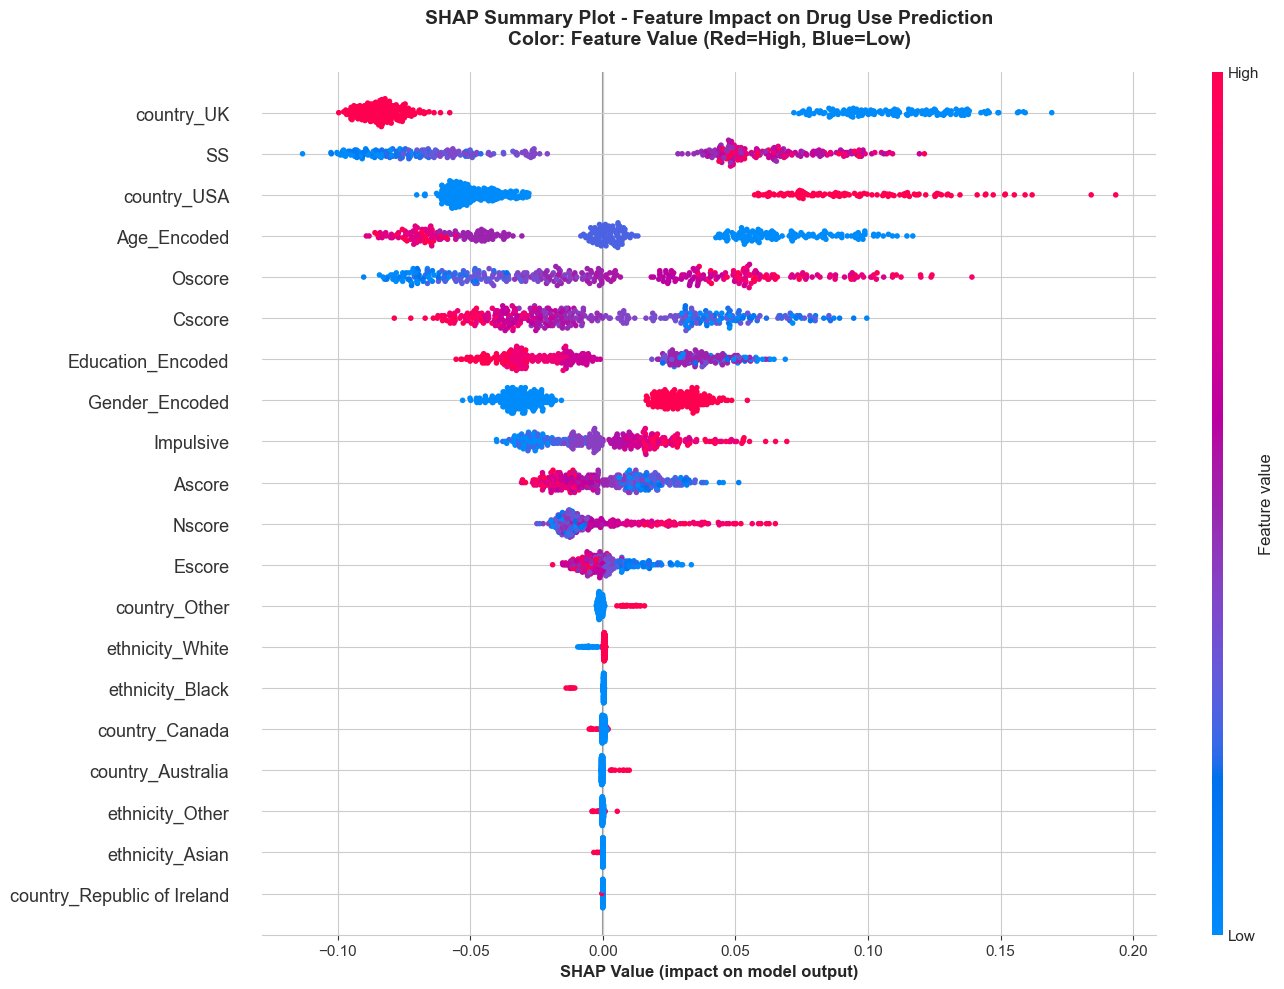


✅ SHAP beeswarm plot saved!
  • File: ../results/figures/31_shap_summary_beeswarm.png

📝 Interpretation Guide:
  • X-axis: SHAP value (impact on prediction)
  • Y-axis: Features (ordered by importance)
  • Color: Feature value (red=high, blue=low)
  • Points: Individual predictions
  • Positive SHAP → Increases drug use probability
  • Negative SHAP → Decreases drug use probability



In [8]:
#==============================================================================
# CELL 8: SHAP SUMMARY PLOT (BEESWARM)
#==============================================================================
"""
Generate SHAP summary plot (beeswarm) - most important visualization.
"""
print("\n" + "="*80)
print("📊 GENERATING SHAP SUMMARY PLOT (Beeswarm)")
print("="*80)

fig = plt.figure(figsize=(14, 10))

# Summary plot (beeswarm)
shap.summary_plot(
    shap_values_class1, 
    X_test,
    feature_names=feature_names,
    show=False,
    plot_size=(14, 10),
    max_display=20
)

plt.title('SHAP Summary Plot - Feature Impact on Drug Use Prediction\n' + 
          'Color: Feature Value (Red=High, Blue=Low)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('SHAP Value (impact on model output)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/31_shap_summary_beeswarm.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP beeswarm plot saved!")
print("  • File: ../results/figures/31_shap_summary_beeswarm.png")

print("\n📝 Interpretation Guide:")
print("  • X-axis: SHAP value (impact on prediction)")
print("  • Y-axis: Features (ordered by importance)")
print("  • Color: Feature value (red=high, blue=low)")
print("  • Points: Individual predictions")
print("  • Positive SHAP → Increases drug use probability")
print("  • Negative SHAP → Decreases drug use probability")

print("\n" + "="*80)


📊 GENERATING SHAP BAR PLOT


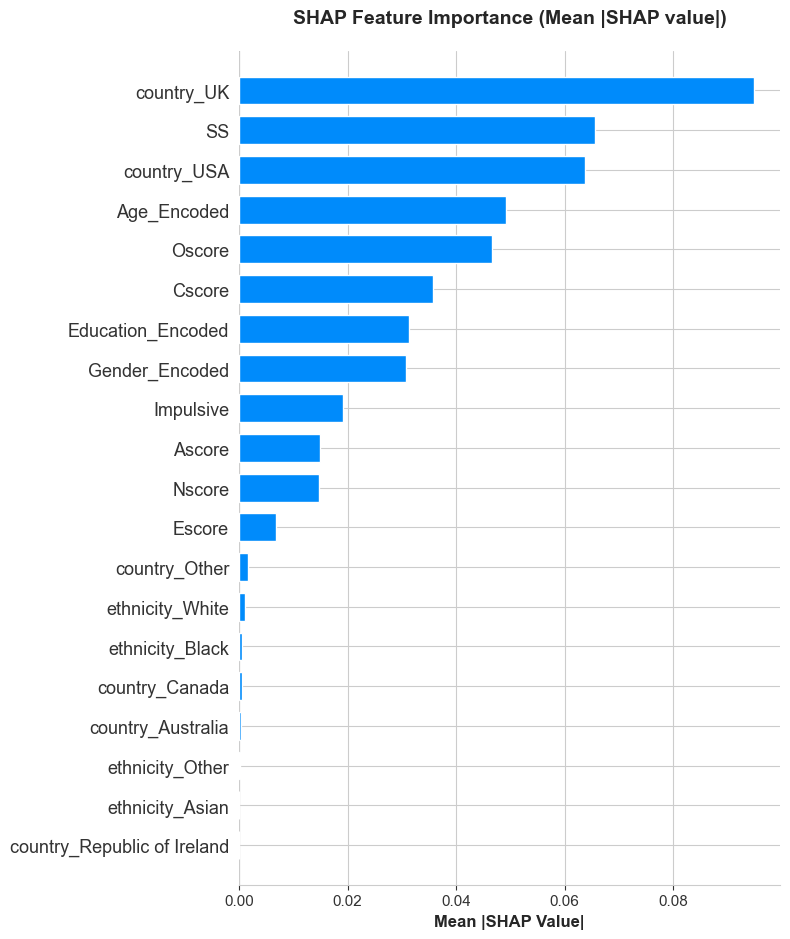


✅ SHAP bar plot saved!
  • File: ../results/figures/32_shap_importance_bar.png



In [9]:
#==============================================================================
# CELL 9: SHAP BAR PLOT (MEAN IMPORTANCE)
#==============================================================================
"""
Generate SHAP bar plot showing mean absolute importance.
"""
print("\n" + "="*80)
print("📊 GENERATING SHAP BAR PLOT")
print("="*80)

fig = plt.figure(figsize=(12, 10))

# Bar plot
shap.summary_plot(
    shap_values_class1,
    X_test,
    feature_names=feature_names,
    plot_type='bar',
    show=False,
    max_display=20
)

plt.title('SHAP Feature Importance (Mean |SHAP value|)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/32_shap_importance_bar.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP bar plot saved!")
print("  • File: ../results/figures/32_shap_importance_bar.png")

print("\n" + "="*80)


📊 GENERATING SHAP DEPENDENCE PLOTS

✅ Creating dependence plots for top 6 features:
  1. country_UK
  2. SS
  3. country_USA
  4. Age_Encoded
  5. Oscore
  6. Cscore


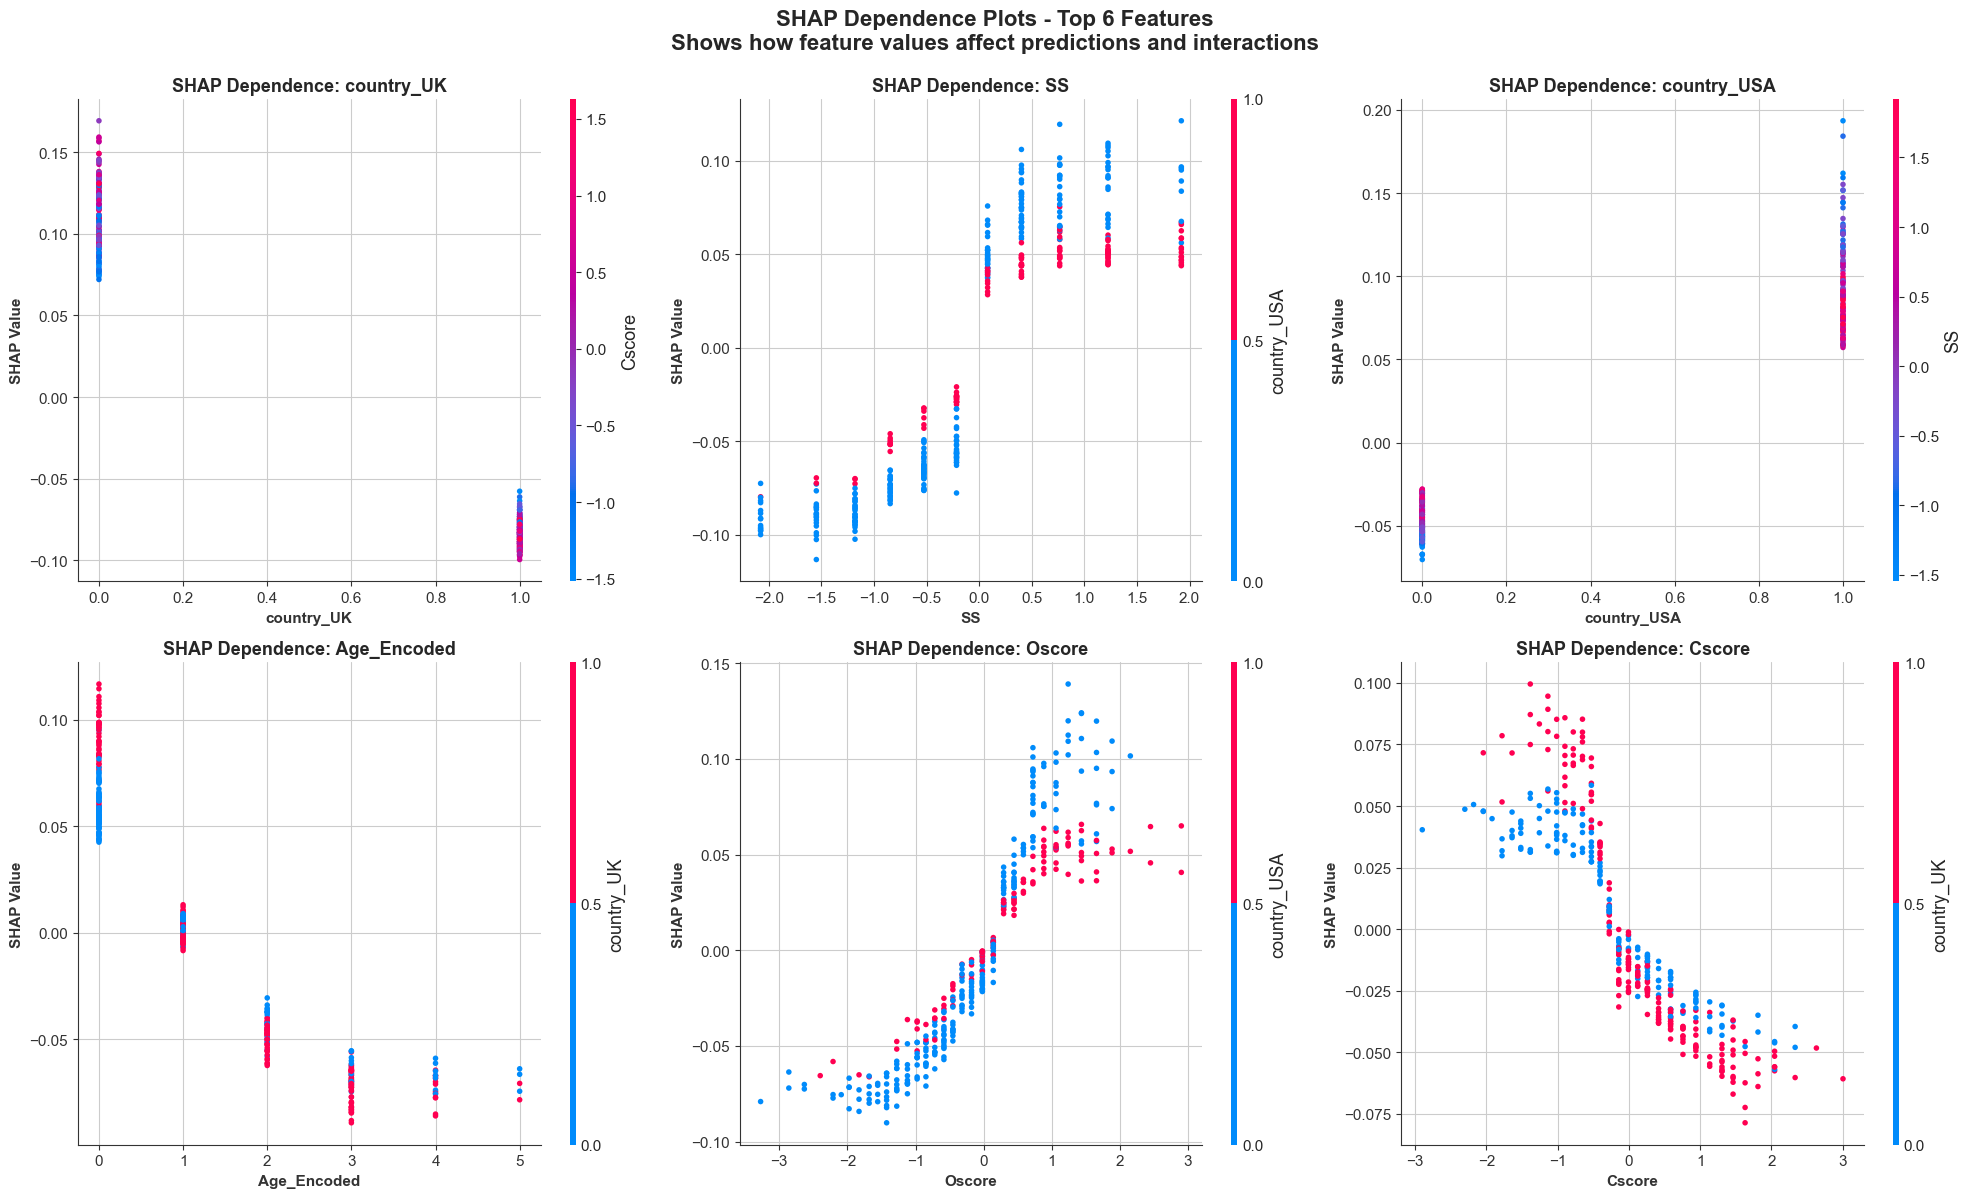


✅ SHAP dependence plots saved!
  • File: ../results/figures/33_shap_dependence_plots.png

📝 Interpretation:
  • X-axis: Feature value
  • Y-axis: SHAP value (impact on prediction)
  • Color: Interaction with another feature
  • Trend: How feature value affects prediction



In [10]:
#==============================================================================
# CELL 10: SHAP DEPENDENCE PLOTS (TOP 6 FEATURES)
#==============================================================================
"""
Generate SHAP dependence plots untuk top 6 features.
"""
print("\n" + "="*80)
print("📊 GENERATING SHAP DEPENDENCE PLOTS")
print("="*80)

# Get top 6 features
top6_features = shap_df.head(6)['Feature'].tolist()

print(f"\n✅ Creating dependence plots for top 6 features:")
for i, feat in enumerate(top6_features, 1):
    print(f"  {i}. {feat}")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(top6_features):
    feature_idx = feature_names.index(feature)
    
    # Create dependence plot
    shap.dependence_plot(
        feature_idx,
        shap_values_class1,
        X_test,
        feature_names=feature_names,
        ax=axes[idx],
        show=False,
        interaction_index='auto'  # Auto-select best interaction feature
    )
    
    axes[idx].set_title(f'SHAP Dependence: {feature}', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(feature, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('SHAP Value', fontsize=11, fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 6 Features\n' +
             'Shows how feature values affect predictions and interactions', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/33_shap_dependence_plots.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP dependence plots saved!")
print("  • File: ../results/figures/33_shap_dependence_plots.png")

print("\n📝 Interpretation:")
print("  • X-axis: Feature value")
print("  • Y-axis: SHAP value (impact on prediction)")
print("  • Color: Interaction with another feature")
print("  • Trend: How feature value affects prediction")

print("\n" + "="*80)


📊 GENERATING SHAP FORCE PLOTS (Individual Predictions)

✅ Sample Selection:
  • High Risk Sample (idx=344):
    - Predicted probability: 0.9939
    - True label: User
  • Low Risk Sample (idx=346):
    - Predicted probability: 0.1104
    - True label: Non-User
  • Borderline Sample (idx=273):
    - Predicted probability: 0.5001
    - True label: Non-User


<Figure size 2000x400 with 0 Axes>

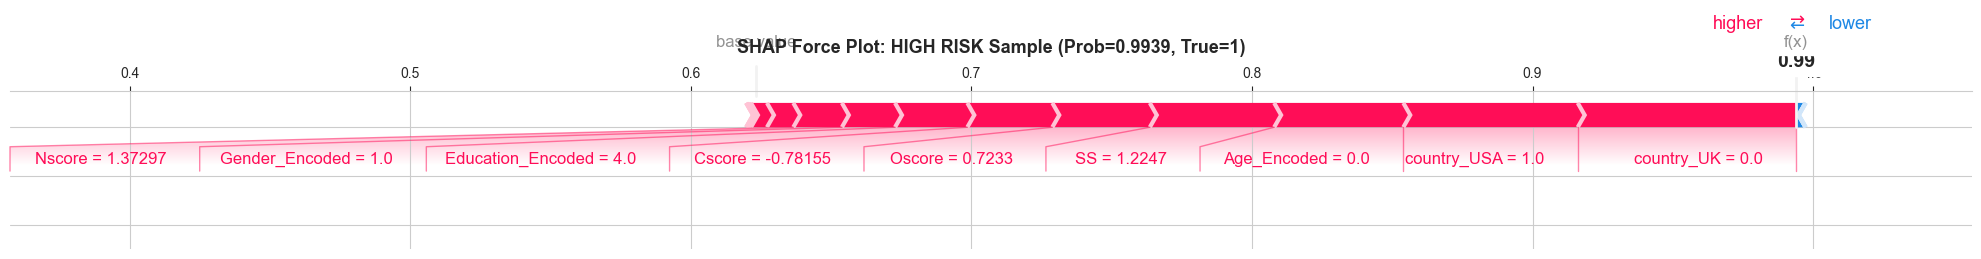

<Figure size 2000x400 with 0 Axes>

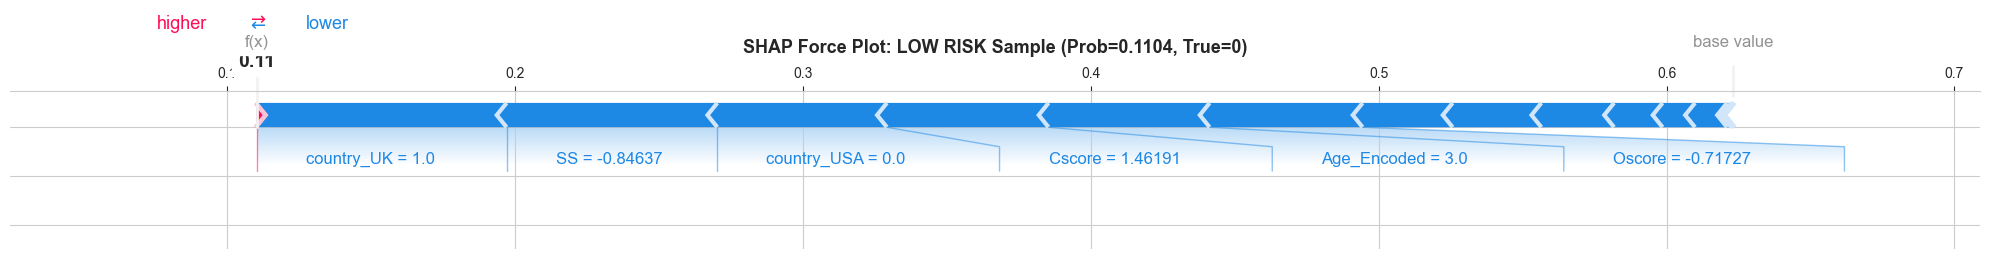

<Figure size 2000x400 with 0 Axes>

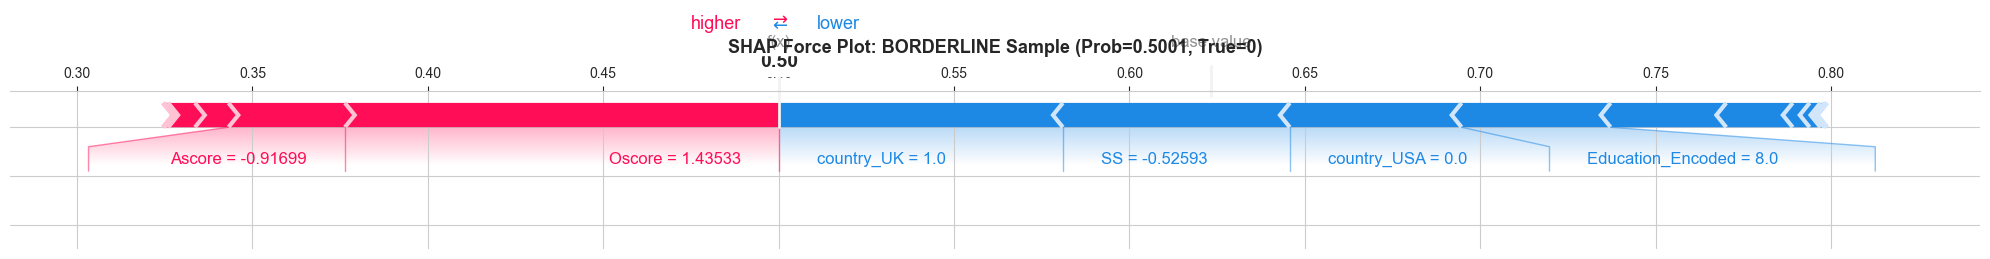


✅ SHAP force plots saved!
  • ../results/figures/34_shap_force_high_risk.png
  • ../results/figures/35_shap_force_low_risk.png
  • ../results/figures/36_shap_force_borderline.png

📝 Force Plot Interpretation:
  • Red features: Push prediction towards drug user (positive SHAP)
  • Blue features: Push prediction towards non-user (negative SHAP)
  • Width: Magnitude of feature's contribution



In [11]:
#==============================================================================
# CELL 11: SHAP FORCE PLOTS (SAMPLE PREDICTIONS)
#==============================================================================
"""
Generate SHAP force plots untuk individual predictions.
"""
print("\n" + "="*80)
print("📊 GENERATING SHAP FORCE PLOTS (Individual Predictions)")
print("="*80)

# Get predictions
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]

# Find high and low risk samples
high_risk_idx = np.argmax(y_pred_proba)
low_risk_idx = np.argmin(y_pred_proba)

# Also get a borderline case (close to 0.5)
borderline_idx = np.argmin(np.abs(y_pred_proba - 0.5))

print(f"\n✅ Sample Selection:")
print(f"  • High Risk Sample (idx={high_risk_idx}):")
print(f"    - Predicted probability: {y_pred_proba[high_risk_idx]:.4f}")
print(f"    - True label: {'User' if y_test[high_risk_idx]==1 else 'Non-User'}")

print(f"  • Low Risk Sample (idx={low_risk_idx}):")
print(f"    - Predicted probability: {y_pred_proba[low_risk_idx]:.4f}")
print(f"    - True label: {'User' if y_test[low_risk_idx]==1 else 'Non-User'}")

print(f"  • Borderline Sample (idx={borderline_idx}):")
print(f"    - Predicted probability: {y_pred_proba[borderline_idx]:.4f}")
print(f"    - True label: {'User' if y_test[borderline_idx]==1 else 'Non-User'}")

# Force plot for high risk
fig = plt.figure(figsize=(20, 4))
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[high_risk_idx, :],
    X_test.iloc[high_risk_idx, :],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot: HIGH RISK Sample (Prob={y_pred_proba[high_risk_idx]:.4f}, True={y_test[high_risk_idx]})',
          fontsize=13, fontweight='bold', pad=10)
plt.tight_layout()
plt.savefig('../results/figures/34_shap_force_high_risk.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Force plot for low risk
fig = plt.figure(figsize=(20, 4))
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[low_risk_idx, :],
    X_test.iloc[low_risk_idx, :],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot: LOW RISK Sample (Prob={y_pred_proba[low_risk_idx]:.4f}, True={y_test[low_risk_idx]})',
          fontsize=13, fontweight='bold', pad=10)
plt.tight_layout()
plt.savefig('../results/figures/35_shap_force_low_risk.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Force plot for borderline
fig = plt.figure(figsize=(20, 4))
shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[borderline_idx, :],
    X_test.iloc[borderline_idx, :],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f'SHAP Force Plot: BORDERLINE Sample (Prob={y_pred_proba[borderline_idx]:.4f}, True={y_test[borderline_idx]})',
          fontsize=13, fontweight='bold', pad=10)
plt.tight_layout()
plt.savefig('../results/figures/36_shap_force_borderline.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP force plots saved!")
print("  • ../results/figures/34_shap_force_high_risk.png")
print("  • ../results/figures/35_shap_force_low_risk.png")
print("  • ../results/figures/36_shap_force_borderline.png")

print("\n📝 Force Plot Interpretation:")
print("  • Red features: Push prediction towards drug user (positive SHAP)")
print("  • Blue features: Push prediction towards non-user (negative SHAP)")
print("  • Width: Magnitude of feature's contribution")

print("\n" + "="*80)


📊 GENERATING SHAP WATERFALL PLOTS


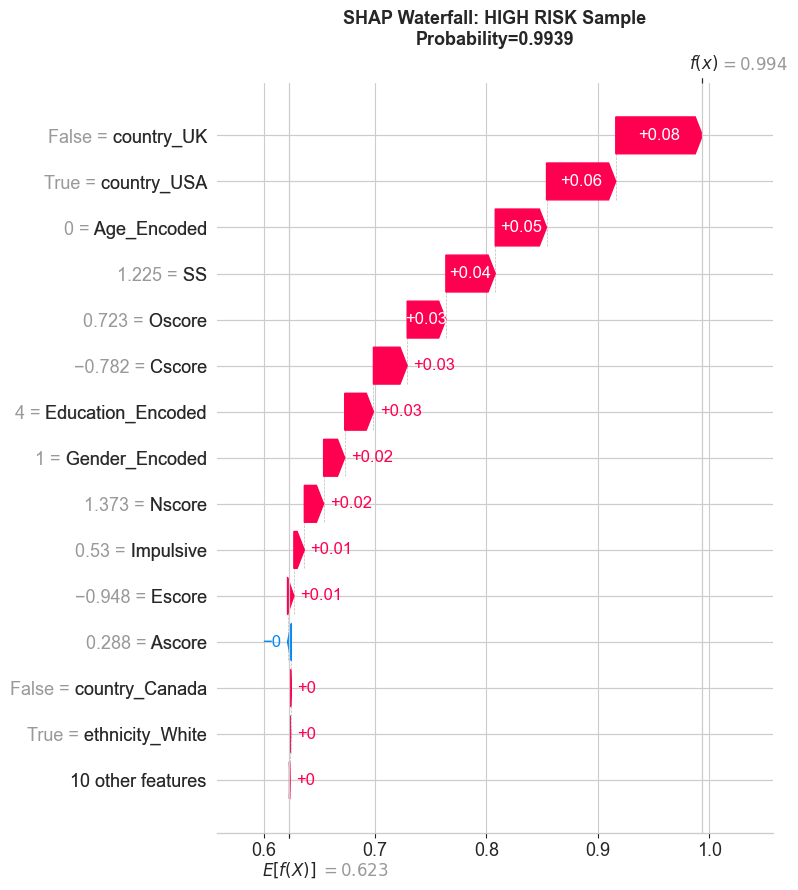

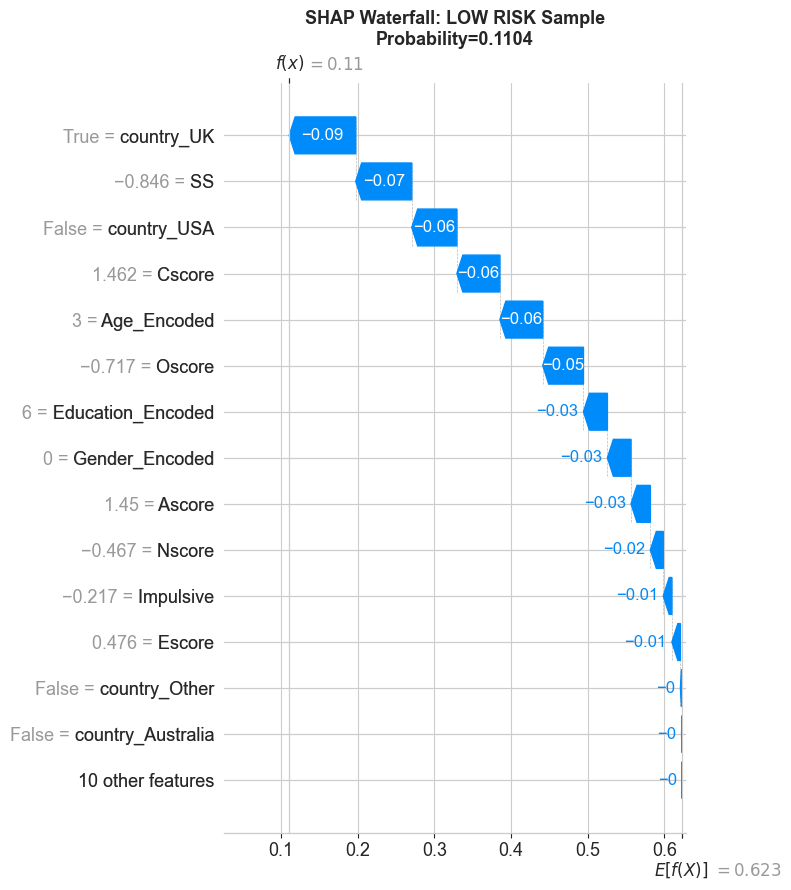


✅ SHAP waterfall plots saved!
  • ../results/figures/37_shap_waterfall_high_risk.png
  • ../results/figures/38_shap_waterfall_low_risk.png

📝 Waterfall Interpretation:
  • Shows cumulative effect of each feature
  • Starts from base value (average prediction)
  • Each bar shows how a feature changes the prediction
  • Final value is the actual prediction



In [12]:
#==============================================================================
# CELL 12: SHAP WATERFALL PLOTS
#==============================================================================
"""
Generate SHAP waterfall plots untuk detailed feature contribution.
"""
print("\n" + "="*80)
print("📊 GENERATING SHAP WATERFALL PLOTS")
print("="*80)

# Waterfall for high risk
fig = plt.figure(figsize=(12, 10))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_class1[high_risk_idx],
        base_values=explainer.expected_value[1],
        data=X_test.iloc[high_risk_idx],
        feature_names=feature_names
    ),
    show=False,
    max_display=15
)
plt.title(f'SHAP Waterfall: HIGH RISK Sample\nProbability={y_pred_proba[high_risk_idx]:.4f}',
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/37_shap_waterfall_high_risk.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Waterfall for low risk
fig = plt.figure(figsize=(12, 10))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_class1[low_risk_idx],
        base_values=explainer.expected_value[1],
        data=X_test.iloc[low_risk_idx],
        feature_names=feature_names
    ),
    show=False,
    max_display=15
)
plt.title(f'SHAP Waterfall: LOW RISK Sample\nProbability={y_pred_proba[low_risk_idx]:.4f}',
          fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/38_shap_waterfall_low_risk.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ SHAP waterfall plots saved!")
print("  • ../results/figures/37_shap_waterfall_high_risk.png")
print("  • ../results/figures/38_shap_waterfall_low_risk.png")

print("\n📝 Waterfall Interpretation:")
print("  • Shows cumulative effect of each feature")
print("  • Starts from base value (average prediction)")
print("  • Each bar shows how a feature changes the prediction")
print("  • Final value is the actual prediction")

print("\n" + "="*80)

In [13]:
#==============================================================================
# CELL 13: COMPARE ALL IMPORTANCE METHODS
#==============================================================================
"""
Compare Gini, Permutation, dan SHAP importance methods.
"""
print("\n" + "="*80)
print("📊 COMPARING ALL IMPORTANCE METHODS")
print("="*80)

# Merge all importance dataframes
comparison_all = gini_df[['Feature', 'Gini_Importance']].copy()
comparison_all = comparison_all.merge(
    perm_df[['Feature', 'Perm_Importance_Mean']], 
    on='Feature'
)
comparison_all = comparison_all.merge(
    shap_df[['Feature', 'SHAP_Importance']], 
    on='Feature'
)

# Normalize all to 0-1 scale for comparison
for col in ['Gini_Importance', 'Perm_Importance_Mean', 'SHAP_Importance']:
    max_val = comparison_all[col].max()
    if max_val > 0:
        comparison_all[f'{col}_Normalized'] = comparison_all[col] / max_val
    else:
        comparison_all[f'{col}_Normalized'] = 0

# Calculate ranks for each method
from scipy.stats import rankdata
comparison_all['Gini_Rank'] = rankdata(-comparison_all['Gini_Importance'])
comparison_all['Perm_Rank'] = rankdata(-comparison_all['Perm_Importance_Mean'])
comparison_all['SHAP_Rank'] = rankdata(-comparison_all['SHAP_Importance'])
comparison_all['Average_Rank'] = comparison_all[['Gini_Rank', 'Perm_Rank', 'SHAP_Rank']].mean(axis=1)

# Sort by average rank
comparison_all = comparison_all.sort_values('Average_Rank').reset_index(drop=True)

print("\n✅ TOP 15 FEATURES - ALL METHODS COMPARISON:")
print("="*80)
display_cols = ['Feature', 'Gini_Rank', 'Perm_Rank', 'SHAP_Rank', 'Average_Rank']
print(comparison_all[display_cols].head(15).to_string(index=False))

# Find consensus features (top 10 in all methods)
top10_gini = set(gini_df.head(10)['Feature'])
top10_perm = set(perm_df.head(10)['Feature'])
top10_shap = set(shap_df.head(10)['Feature'])

consensus_features = top10_gini & top10_perm & top10_shap

print(f"\n✅ CONSENSUS FEATURES (Top 10 in all methods):")
print(f"  • Count: {len(consensus_features)}")
for feat in consensus_features:
    gini_rank = comparison_all[comparison_all['Feature']==feat]['Gini_Rank'].values[0]
    perm_rank = comparison_all[comparison_all['Feature']==feat]['Perm_Rank'].values[0]
    shap_rank = comparison_all[comparison_all['Feature']==feat]['SHAP_Rank'].values[0]
    print(f"  • {feat:25s}: Gini={int(gini_rank):2d}, Perm={int(perm_rank):2d}, SHAP={int(shap_rank):2d}")

print("\n" + "="*80)


📊 COMPARING ALL IMPORTANCE METHODS

✅ TOP 15 FEATURES - ALL METHODS COMPARISON:
          Feature  Gini_Rank  Perm_Rank  SHAP_Rank  Average_Rank
       country_UK     1.0000     1.0000     1.0000        1.0000
               SS     2.0000     3.0000     2.0000        2.3333
      country_USA     3.0000     2.0000     3.0000        2.6667
      Age_Encoded     4.0000     4.0000     4.0000        4.0000
           Oscore     5.0000     5.0000     5.0000        5.0000
           Cscore     6.0000     6.0000     6.0000        6.0000
Education_Encoded     7.0000     7.0000     7.0000        7.0000
   Gender_Encoded    10.0000     8.0000     8.0000        8.6667
           Nscore     9.0000    10.0000    11.0000       10.0000
        Impulsive     8.0000    15.0000     9.0000       10.6667
           Escore    12.0000     9.0000    12.0000       11.0000
    country_Other    13.0000    12.0000    13.0000       12.6667
  ethnicity_White    15.0000    14.0000    14.0000       14.3333
         


📊 VISUALIZING IMPORTANCE METHODS COMPARISON


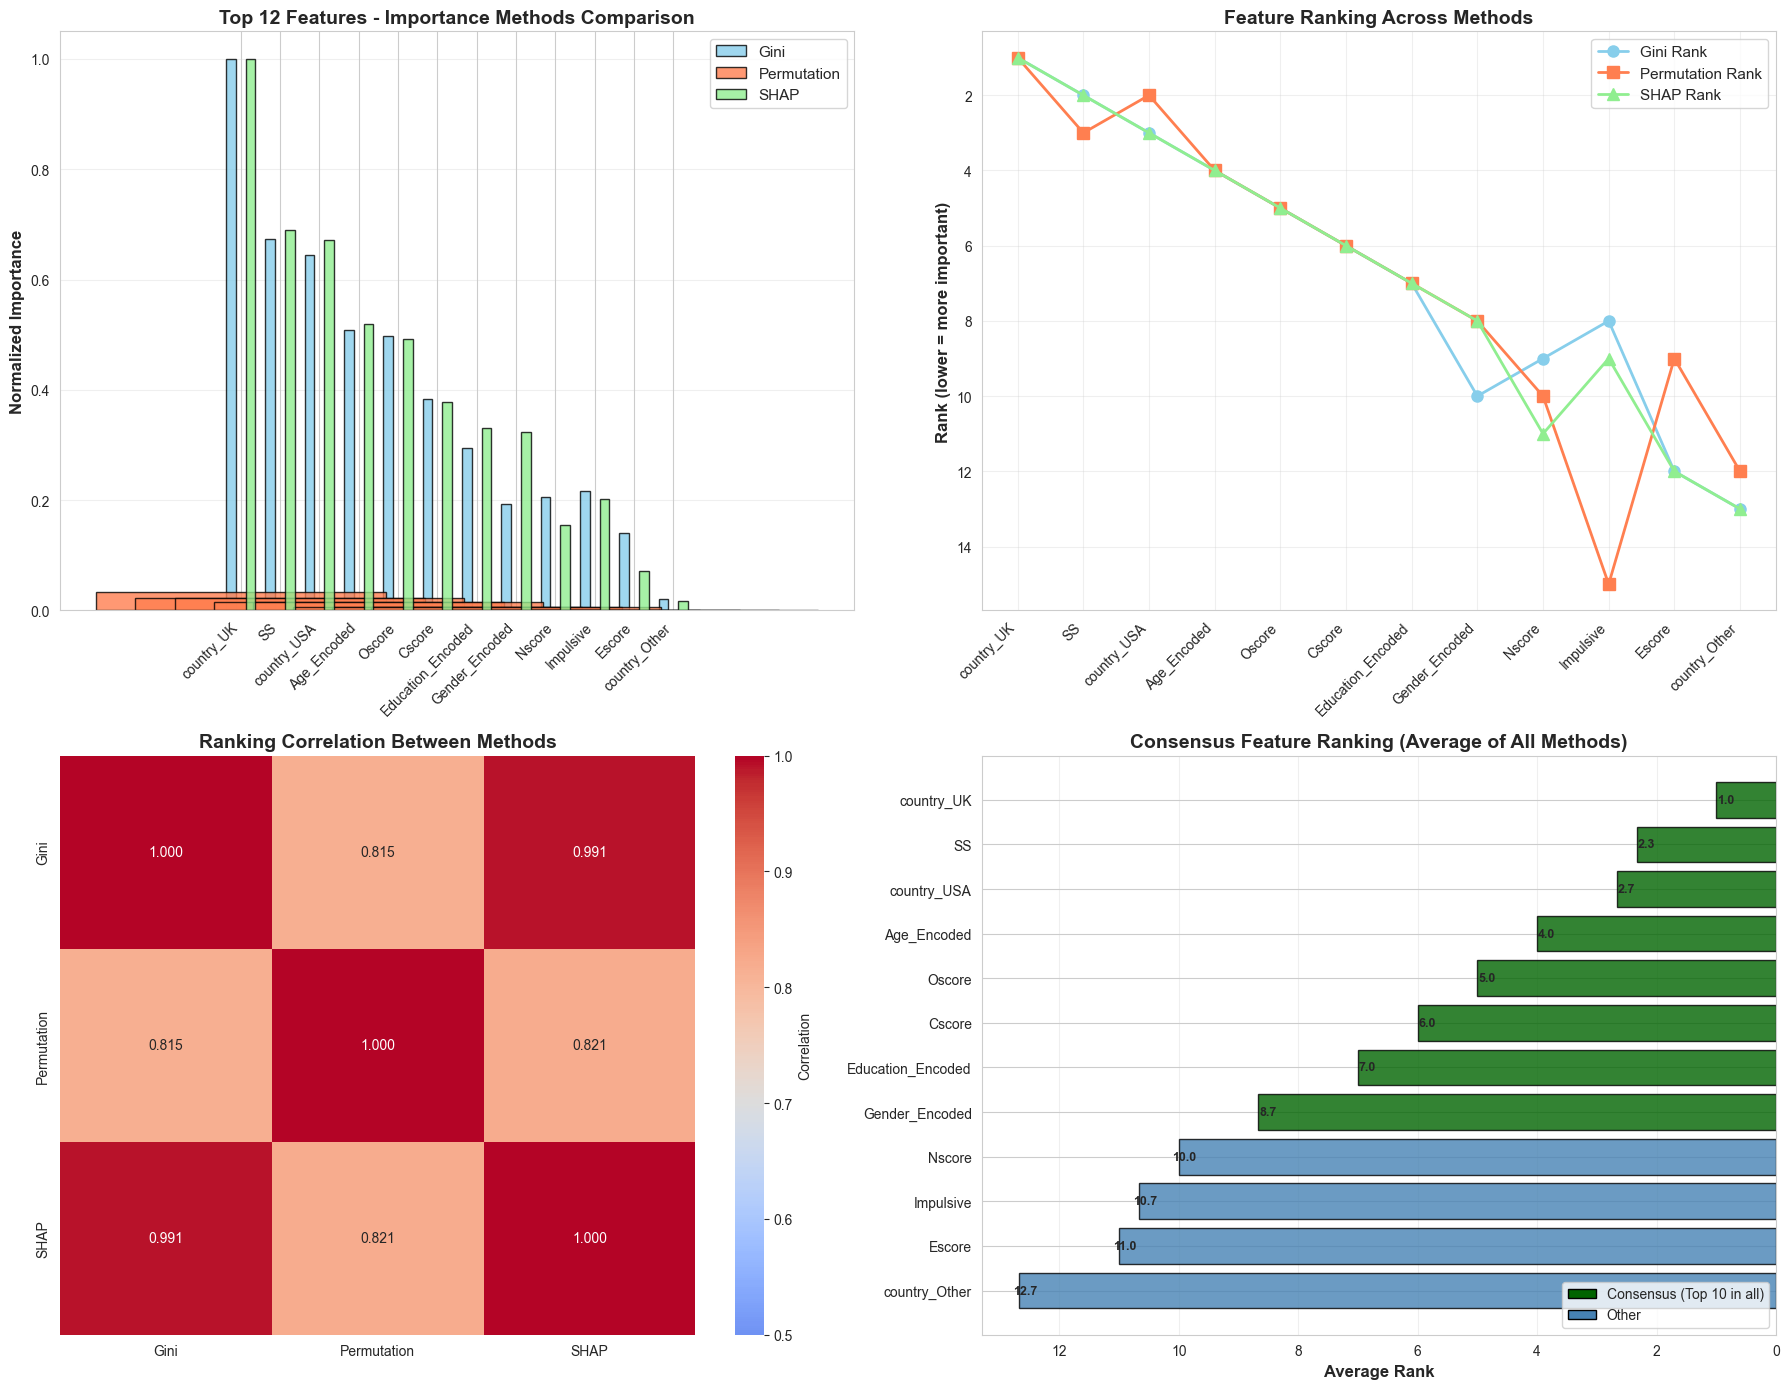


✅ Importance methods comparison saved!
  • File: ../results/figures/39_importance_methods_comparison.png

✅ Method Agreement:
  • Gini vs Permutation: 0.815
  • Gini vs SHAP: 0.991
  • Permutation vs SHAP: 0.821
  • Conclusion: ✅ STRONG AGREEMENT between all methods



In [14]:
#==============================================================================
# CELL 14: VISUALIZE IMPORTANCE METHODS COMPARISON
#==============================================================================
"""
Visualize comparison of all three importance methods.
"""
print("\n" + "="*80)
print("📊 VISUALIZING IMPORTANCE METHODS COMPARISON")
print("="*80)

# Top 12 features by average rank
top12 = comparison_all.head(12)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Normalized importance comparison (bar chart)
ax = axes[0, 0]
x = np.arange(len(top12))
width = 0.25

bars1 = ax.bar(x - width, top12['Gini_Importance_Normalized'], width,
               label='Gini', alpha=0.8, color='skyblue', edgecolor='black')
bars2 = ax.bar(x, top12['Perm_Importance_Mean'], width / top12['Perm_Importance_Mean'].max(),
               label='Permutation', alpha=0.8, color='coral', edgecolor='black')
bars3 = ax.bar(x + width, top12['SHAP_Importance_Normalized'], width,
               label='SHAP', alpha=0.8, color='lightgreen', edgecolor='black')

ax.set_ylabel('Normalized Importance', fontsize=12, fontweight='bold')
ax.set_title('Top 12 Features - Importance Methods Comparison', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top12['Feature'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# 2. Rank comparison (line plot)
ax = axes[0, 1]
ax.plot(range(len(top12)), top12['Gini_Rank'], 'o-', 
        linewidth=2, markersize=8, label='Gini Rank', color='skyblue')
ax.plot(range(len(top12)), top12['Perm_Rank'], 's-', 
        linewidth=2, markersize=8, label='Permutation Rank', color='coral')
ax.plot(range(len(top12)), top12['SHAP_Rank'], '^-', 
        linewidth=2, markersize=8, label='SHAP Rank', color='lightgreen')

ax.set_ylabel('Rank (lower = more important)', fontsize=12, fontweight='bold')
ax.set_title('Feature Ranking Across Methods', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(top12)))
ax.set_xticklabels(top12['Feature'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.invert_yaxis()  # Lower rank at top

# 3. Correlation heatmap of rankings
ax = axes[1, 0]
rank_corr = comparison_all[['Gini_Rank', 'Perm_Rank', 'SHAP_Rank']].corr()
sns.heatmap(rank_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0.7, vmin=0.5, vmax=1.0,
            xticklabels=['Gini', 'Permutation', 'SHAP'],
            yticklabels=['Gini', 'Permutation', 'SHAP'],
            ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Ranking Correlation Between Methods', fontsize=14, fontweight='bold')

# 4. Average rank (final consensus)
ax = axes[1, 1]
colors_consensus = ['darkgreen' if feat in consensus_features else 'steelblue' 
                    for feat in top12['Feature']]
bars = ax.barh(range(len(top12)), top12['Average_Rank'], 
               color=colors_consensus, alpha=0.8, edgecolor='black')
ax.set_yticks(range(len(top12)))
ax.set_yticklabels(top12['Feature'], fontsize=10)
ax.set_xlabel('Average Rank', fontsize=12, fontweight='bold')
ax.set_title('Consensus Feature Ranking (Average of All Methods)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.invert_xaxis()  # Lower rank at right
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(top12.iterrows()):
    ax.text(row['Average_Rank'] - 0.3, i, f"{row['Average_Rank']:.1f}",
            va='center', ha='right', fontsize=9, fontweight='bold')

# Legend for consensus features
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='darkgreen', edgecolor='black', label='Consensus (Top 10 in all)'),
                   Patch(facecolor='steelblue', edgecolor='black', label='Other')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('../results/figures/39_importance_methods_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Importance methods comparison saved!")
print("  • File: ../results/figures/39_importance_methods_comparison.png")

print("\n✅ Method Agreement:")
spearman_gini_perm = rank_corr.loc['Gini_Rank', 'Perm_Rank']
spearman_gini_shap = rank_corr.loc['Gini_Rank', 'SHAP_Rank']
spearman_perm_shap = rank_corr.loc['Perm_Rank', 'SHAP_Rank']

print(f"  • Gini vs Permutation: {spearman_gini_perm:.3f}")
print(f"  • Gini vs SHAP: {spearman_gini_shap:.3f}")
print(f"  • Permutation vs SHAP: {spearman_perm_shap:.3f}")

if spearman_gini_perm > 0.8 and spearman_gini_shap > 0.8 and spearman_perm_shap > 0.8:
    print(f"  • Conclusion: ✅ STRONG AGREEMENT between all methods")
elif spearman_gini_perm > 0.6 and spearman_gini_shap > 0.6 and spearman_perm_shap > 0.6:
    print(f"  • Conclusion: ✅ MODERATE AGREEMENT between methods")
else:
    print(f"  • Conclusion: ⚠️  Some disagreement between methods")

print("\n" + "="*80)

In [15]:
#==============================================================================
# CELL 15: PERSONALITY TRAITS ANALYSIS
#==============================================================================
"""
Analyze personality traits (NEO-FFI-R) contribution.
"""
print("\n" + "="*80)
print("🧠 PERSONALITY TRAITS ANALYSIS (NEO-FFI-R)")
print("="*80)

# Identify personality features
personality_features = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore']
behavioral_features = ['Impulsive', 'SS']
demographic_features = ['Age_Encoded', 'Gender_Encoded', 'Education_Encoded']

# Extract importance for personality traits
personality_importance = comparison_all[
    comparison_all['Feature'].isin(personality_features)
].sort_values('Average_Rank')

behavioral_importance = comparison_all[
    comparison_all['Feature'].isin(behavioral_features)
].sort_values('Average_Rank')

demographic_importance = comparison_all[
    comparison_all['Feature'].isin(demographic_features)
].sort_values('Average_Rank')

print("\n✅ PERSONALITY TRAITS (NEO-FFI-R) IMPORTANCE:")
print("="*80)
for _, row in personality_importance.iterrows():
    print(f"  • {row['Feature']:12s}: " +
          f"Gini={row['Gini_Rank']:4.0f}, " +
          f"Perm={row['Perm_Rank']:4.0f}, " +
          f"SHAP={row['SHAP_Rank']:4.0f}, " +
          f"Avg={row['Average_Rank']:5.1f}")

print("\n✅ BEHAVIORAL MEASURES IMPORTANCE:")
print("-"*80)
for _, row in behavioral_importance.iterrows():
    print(f"  • {row['Feature']:12s}: " +
          f"Gini={row['Gini_Rank']:4.0f}, " +
          f"Perm={row['Perm_Rank']:4.0f}, " +
          f"SHAP={row['SHAP_Rank']:4.0f}, " +
          f"Avg={row['Average_Rank']:5.1f}")

print("\n✅ DEMOGRAPHIC FEATURES IMPORTANCE:")
print("-"*80)
for _, row in demographic_importance.iterrows():
    print(f"  • {row['Feature']:20s}: " +
          f"Gini={row['Gini_Rank']:4.0f}, " +
          f"Perm={row['Perm_Rank']:4.0f}, " +
          f"SHAP={row['SHAP_Rank']:4.0f}, " +
          f"Avg={row['Average_Rank']:5.1f}")

print("\n" + "="*80)


🧠 PERSONALITY TRAITS ANALYSIS (NEO-FFI-R)

✅ PERSONALITY TRAITS (NEO-FFI-R) IMPORTANCE:
  • Oscore      : Gini=   5, Perm=   5, SHAP=   5, Avg=  5.0
  • Cscore      : Gini=   6, Perm=   6, SHAP=   6, Avg=  6.0
  • Nscore      : Gini=   9, Perm=  10, SHAP=  11, Avg= 10.0
  • Escore      : Gini=  12, Perm=   9, SHAP=  12, Avg= 11.0
  • Ascore      : Gini=  11, Perm=  24, SHAP=  10, Avg= 15.0

✅ BEHAVIORAL MEASURES IMPORTANCE:
--------------------------------------------------------------------------------
  • SS          : Gini=   2, Perm=   3, SHAP=   2, Avg=  2.3
  • Impulsive   : Gini=   8, Perm=  15, SHAP=   9, Avg= 10.7

✅ DEMOGRAPHIC FEATURES IMPORTANCE:
--------------------------------------------------------------------------------
  • Age_Encoded         : Gini=   4, Perm=   4, SHAP=   4, Avg=  4.0
  • Education_Encoded   : Gini=   7, Perm=   7, SHAP=   7, Avg=  7.0
  • Gender_Encoded      : Gini=  10, Perm=   8, SHAP=   8, Avg=  8.7




📊 VISUALIZING PERSONALITY TRAITS (Radar Chart)


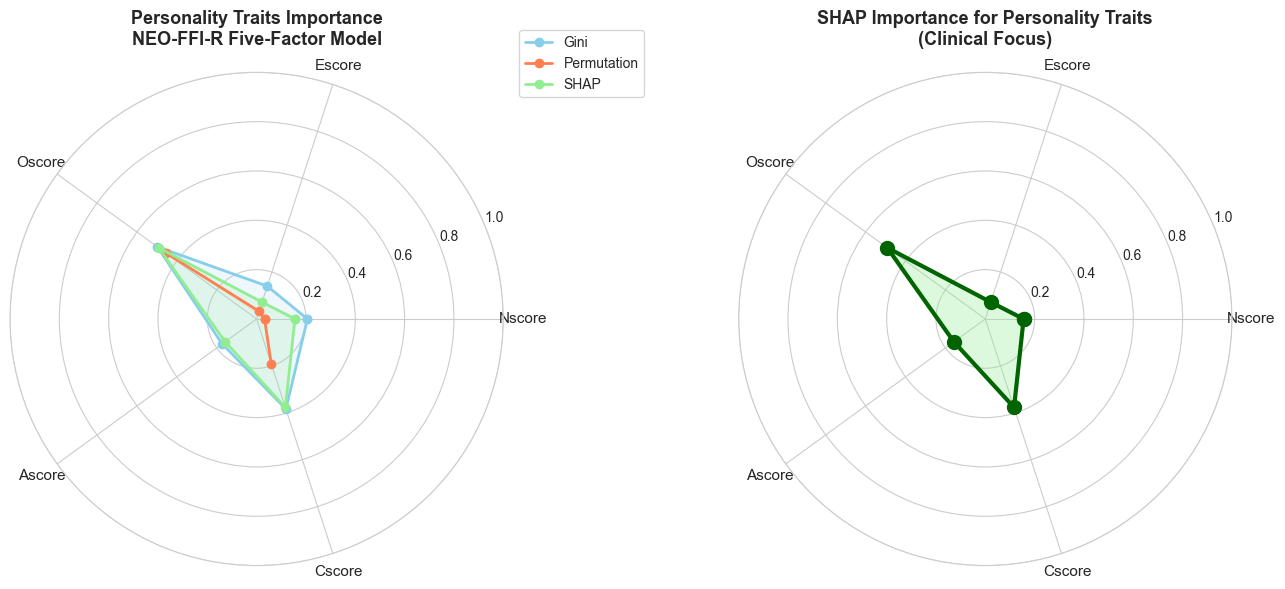


✅ Personality traits radar chart saved!
  • File: ../results/figures/40_personality_traits_radar.png



In [16]:
#==============================================================================
# CELL 16: PERSONALITY RADAR CHART
#==============================================================================
"""
Create radar chart untuk personality traits importance.
"""
print("\n" + "="*80)
print("📊 VISUALIZING PERSONALITY TRAITS (Radar Chart)")
print("="*80)

# Prepare data for radar chart
personality_data = []
for trait in personality_features:
    row = comparison_all[comparison_all['Feature'] == trait].iloc[0]
    personality_data.append({
        'Trait': trait,
        'Gini': row['Gini_Importance_Normalized'],
        'Permutation': row['Perm_Importance_Mean'] / comparison_all['Perm_Importance_Mean'].max(),
        'SHAP': row['SHAP_Importance_Normalized']
    })

personality_radar_df = pd.DataFrame(personality_data)

# Create radar chart
fig = plt.figure(figsize=(14, 6))

# Subplot 1: All three methods
ax1 = fig.add_subplot(121, projection='polar')

angles = np.linspace(0, 2 * np.pi, len(personality_features), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

for method, color in [('Gini', 'skyblue'), ('Permutation', 'coral'), ('SHAP', 'lightgreen')]:
    values = personality_radar_df[method].tolist()
    values += values[:1]  # Complete the circle
    
    ax1.plot(angles, values, 'o-', linewidth=2, label=method, color=color)
    ax1.fill(angles, values, alpha=0.15, color=color)

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(personality_features, fontsize=11)
ax1.set_ylim(0, 1)
ax1.set_title('Personality Traits Importance\nNEO-FFI-R Five-Factor Model', 
              fontsize=13, fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax1.grid(True)

# Subplot 2: SHAP only with clinical interpretation
ax2 = fig.add_subplot(122, projection='polar')

shap_values_personality = personality_radar_df['SHAP'].tolist()
shap_values_personality += shap_values_personality[:1]

ax2.plot(angles, shap_values_personality, 'o-', linewidth=3, color='darkgreen', markersize=10)
ax2.fill(angles, shap_values_personality, alpha=0.3, color='lightgreen')

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(personality_features, fontsize=11)
ax2.set_ylim(0, 1)
ax2.set_title('SHAP Importance for Personality Traits\n(Clinical Focus)', 
              fontsize=13, fontweight='bold', pad=20)
ax2.grid(True)

plt.tight_layout()
plt.savefig('../results/figures/40_personality_traits_radar.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Personality traits radar chart saved!")
print("  • File: ../results/figures/40_personality_traits_radar.png")

print("\n" + "="*80)

In [17]:
#==============================================================================
# CELL 17: CLINICAL INTERPRETATION
#==============================================================================
"""
Generate clinical interpretation untuk top features.
"""
print("\n" + "="*80)
print("🏥 CLINICAL INTERPRETATION OF TOP FEATURES")
print("="*80)

# Clinical interpretation dictionary
clinical_interpretations = {
    'Nscore': {
        'full_name': 'Neuroticism',
        'description': 'Emotional instability, anxiety, and negative emotionality',
        'clinical_relevance': 'Higher neuroticism linked to vulnerability to stress and substance use as coping mechanism',
        'intervention': 'Anxiety management, cognitive-behavioral therapy, stress reduction techniques'
    },
    'Escore': {
        'full_name': 'Extraversion',
        'description': 'Social engagement, assertiveness, and positive emotionality',
        'clinical_relevance': 'Higher extraversion may increase exposure to peer influence and social drug use contexts',
        'intervention': 'Peer resistance training, healthy social activity alternatives'
    },
    'Oscore': {
        'full_name': 'Openness to Experience',
        'description': 'Curiosity, creativity, and willingness to try new experiences',
        'clinical_relevance': 'Strong predictor - novelty seeking directly correlates with experimentation and drug use',
        'intervention': 'Channel curiosity into safe activities, adventure therapy, creative outlets'
    },
    'Ascore': {
        'full_name': 'Agreeableness',
        'description': 'Cooperation, compassion, and social harmony',
        'clinical_relevance': 'Lower agreeableness associated with rule-breaking and risk-taking behaviors',
        'intervention': 'Social skills training, empathy development, prosocial activities'
    },
    'Cscore': {
        'full_name': 'Conscientiousness',
        'description': 'Self-discipline, organization, and impulse control',
        'clinical_relevance': 'CRITICAL - Lower conscientiousness means poor self-control and impulsivity',
        'intervention': 'Self-monitoring skills, goal-setting, delayed gratification training'
    },
    'Impulsive': {
        'full_name': 'Impulsiveness (BIS-11)',
        'description': 'Tendency to act without thinking',
        'clinical_relevance': 'Direct predictor of substance experimentation and risky behaviors',
        'intervention': 'Impulse control therapy, mindfulness, pause-and-reflect techniques'
    },
    'SS': {
        'full_name': 'Sensation Seeking (ImpSS)',
        'description': 'Need for novel and intense experiences',
        'clinical_relevance': 'STRONGEST PREDICTOR - Directly drives substance experimentation',
        'intervention': 'Safe thrill-seeking alternatives (sports, adventure activities)'
    },
    'Age_Encoded': {
        'full_name': 'Age Group',
        'description': 'Chronological age category',
        'clinical_relevance': 'Younger individuals at highest risk due to brain development and peer influence',
        'intervention': 'Age-appropriate prevention programs, early intervention focus'
    },
    'Education_Encoded': {
        'full_name': 'Education Level',
        'description': 'Formal educational attainment',
        'clinical_relevance': 'Education affects knowledge, decision-making, and access to resources',
        'intervention': 'Educational support, health literacy programs'
    },
    'Gender_Encoded': {
        'full_name': 'Gender',
        'description': 'Biological sex',
        'clinical_relevance': 'Gender differences in drug use patterns and risk factors',
        'intervention': 'Gender-specific prevention and treatment approaches'
    }
}

# Get top 10 features by consensus
top10_consensus = comparison_all.head(10)

print("\n✅ CLINICAL INTERPRETATION: TOP 10 FEATURES")
print("="*80)

for i, (idx, row) in enumerate(top10_consensus.iterrows(), 1):
    feature = row['Feature']
    avg_rank = row['Average_Rank']
    
    print(f"\n{i}. {feature} (Average Rank: {avg_rank:.1f})")
    print("-" * 80)
    
    if feature in clinical_interpretations:
        info = clinical_interpretations[feature]
        print(f"   Full Name: {info['full_name']}")
        print(f"   Description: {info['description']}")
        print(f"   Clinical Relevance: {info['clinical_relevance']}")
        print(f"   Intervention: {info['intervention']}")
    else:
        # For country/ethnicity variables
        print(f"   Geographic/Demographic Variable")
        print(f"   Clinical Relevance: Cultural and environmental factors affecting drug availability and norms")
        print(f"   Intervention: Community-based prevention, cultural sensitivity in treatment")
    
    # Add SHAP analysis
    shap_rank = row['SHAP_Rank']
    if shap_rank <= 5:
        print(f"   SHAP Analysis: ⭐ TOP 5 - CRITICAL predictor")
    elif shap_rank <= 10:
        print(f"   SHAP Analysis: ✅ TOP 10 - Important predictor")
    else:
        print(f"   SHAP Analysis: ⚠️  Moderate importance")

print("\n" + "="*80)


🏥 CLINICAL INTERPRETATION OF TOP FEATURES

✅ CLINICAL INTERPRETATION: TOP 10 FEATURES

1. country_UK (Average Rank: 1.0)
--------------------------------------------------------------------------------
   Geographic/Demographic Variable
   Clinical Relevance: Cultural and environmental factors affecting drug availability and norms
   Intervention: Community-based prevention, cultural sensitivity in treatment
   SHAP Analysis: ⭐ TOP 5 - CRITICAL predictor

2. SS (Average Rank: 2.3)
--------------------------------------------------------------------------------
   Full Name: Sensation Seeking (ImpSS)
   Description: Need for novel and intense experiences
   Clinical Relevance: STRONGEST PREDICTOR - Directly drives substance experimentation
   Intervention: Safe thrill-seeking alternatives (sports, adventure activities)
   SHAP Analysis: ⭐ TOP 5 - CRITICAL predictor

3. country_USA (Average Rank: 2.7)
--------------------------------------------------------------------------------
   Ge

In [18]:
#==============================================================================
# CELL 18: FEATURE GROUPS ANALYSIS
#==============================================================================
"""
Analyze importance by feature groups.
"""
print("\n" + "="*80)
print("📊 FEATURE GROUPS ANALYSIS")
print("="*80)

# Define feature groups
feature_groups = {
    'Personality (NEO-FFI-R)': personality_features,
    'Behavioral Measures': behavioral_features,
    'Demographics': demographic_features,
    'Country': [f for f in feature_names if f.startswith('country_')],
    'Ethnicity': [f for f in feature_names if f.startswith('ethnicity_')]
}

# Calculate group importance
group_importance = []
for group_name, features in feature_groups.items():
    group_features = comparison_all[comparison_all['Feature'].isin(features)]
    
    if len(group_features) > 0:
        avg_rank = group_features['Average_Rank'].mean()
        total_shap = comparison_all[comparison_all['Feature'].isin(features)]['SHAP_Importance'].sum()
        n_features = len(features)
        n_top10 = len(group_features[group_features['Average_Rank'] <= 10])
        
        group_importance.append({
            'Group': group_name,
            'N_Features': n_features,
            'N_in_Top10': n_top10,
            'Avg_Rank': avg_rank,
            'Total_SHAP': total_shap,
            'Avg_SHAP': total_shap / n_features
        })

group_df = pd.DataFrame(group_importance).sort_values('Avg_Rank')

print("\n✅ FEATURE GROUPS IMPORTANCE RANKING:")
print("="*80)
print(group_df.to_string(index=False))

print("\n✅ Group Analysis:")
for _, row in group_df.iterrows():
    group = row['Group']
    n_top10 = row['N_in_Top10']
    n_total = row['N_Features']
    avg_rank = row['Avg_Rank']
    
    print(f"\n  • {group}:")
    print(f"    - {n_top10}/{n_total} features in top 10 ({n_top10/n_total*100:.0f}%)")
    print(f"    - Average rank: {avg_rank:.1f}")
    
    if avg_rank < 8:
        print(f"    - Status: ⭐ CRITICAL GROUP - High importance")
    elif avg_rank < 12:
        print(f"    - Status: ✅ IMPORTANT GROUP")
    else:
        print(f"    - Status: ⚠️  Moderate importance")

print("\n" + "="*80)


📊 FEATURE GROUPS ANALYSIS

✅ FEATURE GROUPS IMPORTANCE RANKING:
                  Group  N_Features  N_in_Top10  Avg_Rank  Total_SHAP  Avg_SHAP
    Behavioral Measures           2           1    6.5000      0.0847    0.0424
           Demographics           3           3    6.5556      0.1114    0.0371
Personality (NEO-FFI-R)           5           3    9.4000      0.1189    0.0238
                Country           7           2   13.1429      0.1612    0.0230
              Ethnicity           7           0   18.3333      0.0020    0.0003

✅ Group Analysis:

  • Behavioral Measures:
    - 1/2 features in top 10 (50%)
    - Average rank: 6.5
    - Status: ⭐ CRITICAL GROUP - High importance

  • Demographics:
    - 3/3 features in top 10 (100%)
    - Average rank: 6.6
    - Status: ⭐ CRITICAL GROUP - High importance

  • Personality (NEO-FFI-R):
    - 3/5 features in top 10 (60%)
    - Average rank: 9.4
    - Status: ✅ IMPORTANT GROUP

  • Country:
    - 2/7 features in top 10 (29%)
    


📊 VISUALIZING FEATURE GROUPS


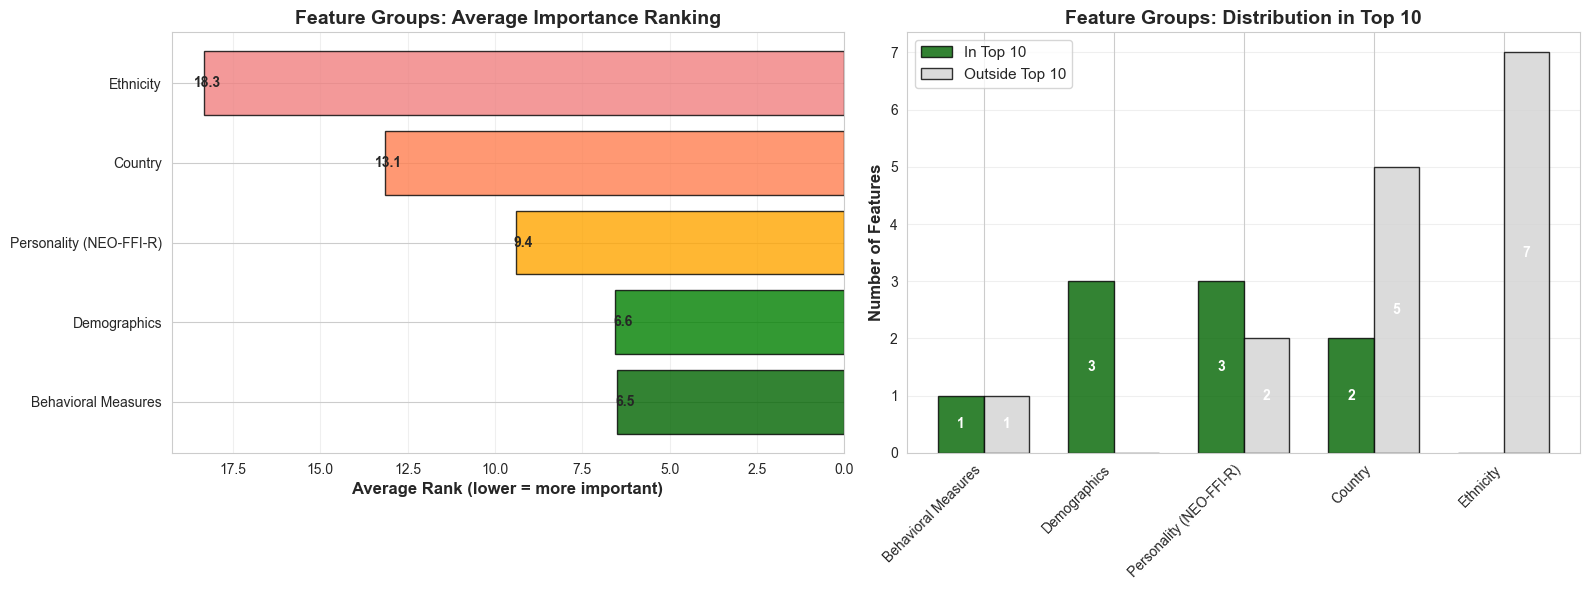


✅ Feature groups visualization saved!
  • File: ../results/figures/41_feature_groups_analysis.png



In [19]:
#==============================================================================
# CELL 19: VISUALIZE FEATURE GROUPS
#==============================================================================
"""
Visualize feature groups comparison.
"""
print("\n" + "="*80)
print("📊 VISUALIZING FEATURE GROUPS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Group average importance
ax = axes[0]
colors_group = ['darkgreen', 'green', 'orange', 'coral', 'lightcoral']
bars = ax.barh(group_df['Group'], group_df['Avg_Rank'], 
               color=colors_group[:len(group_df)], alpha=0.8, edgecolor='black')

ax.set_xlabel('Average Rank (lower = more important)', fontsize=12, fontweight='bold')
ax.set_title('Feature Groups: Average Importance Ranking', 
             fontsize=14, fontweight='bold')
ax.invert_xaxis()  # Lower rank on right
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(group_df.iterrows()):
    ax.text(row['Avg_Rank'] - 0.5, i, f"{row['Avg_Rank']:.1f}",
            va='center', ha='right', fontsize=10, fontweight='bold')

# 2. Features in top 10 by group
ax = axes[1]
x = np.arange(len(group_df))
width = 0.35

bars1 = ax.bar(x - width/2, group_df['N_in_Top10'], width,
               label='In Top 10', alpha=0.8, color='darkgreen', edgecolor='black')
bars2 = ax.bar(x + width/2, group_df['N_Features'] - group_df['N_in_Top10'], width,
               label='Outside Top 10', alpha=0.8, color='lightgray', edgecolor='black')

ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Groups: Distribution in Top 10', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(group_df['Group'], rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{int(height)}',
                    ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.savefig('../results/figures/41_feature_groups_analysis.png', 
            dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature groups visualization saved!")
print("  • File: ../results/figures/41_feature_groups_analysis.png")

print("\n" + "="*80)

In [20]:
#==============================================================================
# CELL 20: SAVE ALL RESULTS
#==============================================================================
"""
Save all SHAP analysis results.
"""
print("\n" + "="*80)
print("SAVING ALL SHAP ANALYSIS RESULTS")
print("="*80)

# 1. Save Gini importance
print("\n1️⃣  Saving Gini importance...")
gini_df.to_csv('../results/metrics/05_gini_importance.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_gini_importance.csv")

# 2. Save permutation importance
print("\n2️⃣  Saving permutation importance...")
perm_df.to_csv('../results/metrics/05_permutation_importance.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_permutation_importance.csv")

# 3. Save SHAP importance
print("\n3️⃣  Saving SHAP importance...")
shap_df.to_csv('../results/metrics/05_shap_importance.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_shap_importance.csv")

# 4. Save comparison of all methods
print("\n4️⃣  Saving importance methods comparison...")
comparison_all.to_csv('../results/metrics/05_all_importance_comparison.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_all_importance_comparison.csv")

# 5. Save personality traits analysis
print("\n5️⃣  Saving personality traits analysis...")
personality_importance.to_csv('../results/metrics/05_personality_importance.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_personality_importance.csv")

# 6. Save feature groups analysis
print("\n6️⃣  Saving feature groups analysis...")
group_df.to_csv('../results/metrics/05_feature_groups.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_feature_groups.csv")

# 7. Save SHAP values (for further analysis)
print("\n7️⃣  Saving SHAP values matrix...")
shap_values_df = pd.DataFrame(shap_values_class1, columns=feature_names)
shap_values_df.to_csv('../results/metrics/05_shap_values_matrix.csv', index=False)
print("  ✅ Saved: ../results/metrics/05_shap_values_matrix.csv")

# 8. Save comprehensive JSON
print("\n8️⃣  Saving comprehensive SHAP results JSON...")

shap_results_json = {
    'analysis_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': type(tuned_model).__name__,
        'n_features': len(feature_names),
        'n_samples': len(X_test),
        'base_value': float(explainer.expected_value[1]),
        'computation_time_seconds': float(shap_time)
    },
    'top_features': {
        'gini_top10': gini_df.head(10)['Feature'].tolist(),
        'permutation_top10': perm_df.head(10)['Feature'].tolist(),
        'shap_top10': shap_df.head(10)['Feature'].tolist(),
        'consensus_features': list(consensus_features)
    },
    'feature_importance_summary': {
        row['Feature']: {
            'gini_rank': int(row['Gini_Rank']),
            'perm_rank': int(row['Perm_Rank']),
            'shap_rank': int(row['SHAP_Rank']),
            'average_rank': float(row['Average_Rank']),
            'gini_importance': float(row['Gini_Importance']),
            'perm_importance': float(row['Perm_Importance_Mean']),
            'shap_importance': float(row['SHAP_Importance'])
        } for _, row in comparison_all.head(20).iterrows()
    },
}


SAVING ALL SHAP ANALYSIS RESULTS

1️⃣  Saving Gini importance...
  ✅ Saved: ../results/metrics/05_gini_importance.csv

2️⃣  Saving permutation importance...
  ✅ Saved: ../results/metrics/05_permutation_importance.csv

3️⃣  Saving SHAP importance...
  ✅ Saved: ../results/metrics/05_shap_importance.csv

4️⃣  Saving importance methods comparison...
  ✅ Saved: ../results/metrics/05_all_importance_comparison.csv

5️⃣  Saving personality traits analysis...
  ✅ Saved: ../results/metrics/05_personality_importance.csv

6️⃣  Saving feature groups analysis...
  ✅ Saved: ../results/metrics/05_feature_groups.csv

7️⃣  Saving SHAP values matrix...
  ✅ Saved: ../results/metrics/05_shap_values_matrix.csv

8️⃣  Saving comprehensive SHAP results JSON...
